# Índice

- [Descarga de datos](#descarga)
- [Carga de datos](#carga)
- [Limpieza de datos](#limpieza)
- [Análisis descriptivo](#analisis)
- [Modelo y ajuste de parámetros](#model)
    - [Linear Regression](#lr)
    - [PCA](#pca)
    - [Random Forest](#rf)
    - [Cross Validation](#cv)
- [Conclusión final](#conclusion)


    
<div id="xx" />

Para completar esta tarea, deberás generar dos pequeños modelos de Machine Learning con Sparkml utilizando el conjunto de datos que se encuentra en https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip.

Utilizar el dataset student-mat.csv para esta práctica y ver la descripción de los campos en el fichero student.txt

Los modelos a implementar (los algoritmos a elección del alumno) en concreto serán de dos tipos:

    Un modelo de regresión (u otro tipo predictivo) en el que se haga predicción del valor de la nota final (G3) en base al resto de variables numéricas
    Un modelo de clasificación en el que se clasifique a los alumnos como aprobados o suspendidos (G3 > ó < que 10)

Para la construcción de los modelos se valorarán estos pasos:

    Carga del fichero de datos en un RDD.
    Mediante operaciones sobre el RDD quedarse únicamente con los campos numéricos y añadir un nuevo campo que a partir de la nota (G3) tome un valor de “aprobado/suspendido” (1/0) dependiendo de si la nota es mayor o menor que 10.
    Creación de un DataFrame Spark a partir del RDD anterior.
    Sobre ese DataFrame aplicar todos los pasos necesarios que se han visto en los ejemplos del manual para construir el modelo de regresión (predicción) comentado anteriormente y su posterior evaluación (medición de errores sobre test y training).
    Idem para el modelo de clasificación
    Se valorará como un extra la utilización de funciones de correlación para eliminación de predictores altamente correlados y la construcción del modelo utilizando técnicas de cross-validation


<div id="descarga" />

## Descarga de datos

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
!mv student.zip ../data
!unzip ../data/student.zip -d ../data/student

--2022-01-11 18:16:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20478 (20K) [application/x-httpd-php]
Saving to: ‘student.zip’

student.zip         100%[===================>]  20.00K   118KB/s    in 0.2s    

2022-01-11 18:16:02 (118 KB/s) - ‘student.zip’ saved [20478/20478]

Archive:  ../data/student.zip
  inflating: ../data/student/student-mat.csv  
  inflating: ../data/student/student-por.csv  
  inflating: ../data/student/student-merge.R  
  inflating: ../data/student/student.txt  


<div id="carga" />

## Carga de datos

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext()
spark = SparkSession(sc)

data = sc.textFile("../data/student/student-mat.csv")

sc.version

'2.4.5'

In [3]:
data.collect()

['school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3',
 '"GP";"F";18;"U";"GT3";"A";4;4;"at_home";"teacher";"course";"mother";2;2;0;"yes";"no";"no";"no";"yes";"yes";"no";"no";4;3;4;1;1;3;6;"5";"6";6',
 '"GP";"F";17;"U";"GT3";"T";1;1;"at_home";"other";"course";"father";1;2;0;"no";"yes";"no";"no";"no";"yes";"yes";"no";5;3;3;1;1;3;4;"5";"5";6',
 '"GP";"F";15;"U";"LE3";"T";1;1;"at_home";"other";"other";"mother";1;2;3;"yes";"no";"yes";"no";"yes";"yes";"yes";"no";4;3;2;2;3;3;10;"7";"8";10',
 '"GP";"F";15;"U";"GT3";"T";4;2;"health";"services";"home";"mother";1;3;0;"no";"yes";"yes";"yes";"yes";"yes";"yes";"yes";3;2;2;1;1;5;2;"15";"14";15',
 '"GP";"F";16;"U";"GT3";"T";3;3;"other";"other";"home";"father";1;2;0;"no";"yes";"yes";"no";"yes";"yes";"no";"no";4;3;2;1;2;5;4;"6";"10";10',
 '"GP";"M";16;"U";"LE3";"T";4;3;"services"

<div id="limpieza" />

## Limpieza de datos

In [4]:
from pyspark.sql import Row

# Eliminamos cabeceras
headers = data.first()
rdd = data.filter(lambda line: line != headers)

rdd = rdd.map(lambda x: x.replace("\"","")).map(lambda x: x.split(";"))

rdd = rdd.map(lambda x: Row(age=int(x[2]), Medu=int(x[6]), Fedu=int(x[7]), traveltime=int(x[12]), 
                            studytime=int(x[13]), failures=int(x[14]), famrel=int(x[23]), freetime=int(x[24]), 
                            goout=int(x[25]), Dalc=int(x[26]), Walc=int(x[27]), health=int(x[28]), 
                            absences=int(x[29]), G1=int(x[30]), G2=int(x[31]), G3=int(x[32])))

df = spark.createDataFrame(rdd)
df.show(3)

+----+----+---+---+---+----+----+--------+---+--------+------+--------+-----+------+---------+----------+
|Dalc|Fedu| G1| G2| G3|Medu|Walc|absences|age|failures|famrel|freetime|goout|health|studytime|traveltime|
+----+----+---+---+---+----+----+--------+---+--------+------+--------+-----+------+---------+----------+
|   1|   4|  5|  6|  6|   4|   1|       6| 18|       0|     4|       3|    4|     3|        2|         2|
|   1|   1|  5|  5|  6|   1|   1|       4| 17|       0|     5|       3|    3|     3|        2|         1|
|   2|   1|  7|  8| 10|   1|   3|      10| 15|       3|     4|       3|    2|     3|        2|         1|
+----+----+---+---+---+----+----+--------+---+--------+------+--------+-----+------+---------+----------+
only showing top 3 rows



<div id="analisis" />

## Análisis descriptivo

Veamos algunas estadísticas de la variable nota en función del trimestre

In [5]:
df.select("G1", "G2", "G3").describe().show()

+-------+-----------------+------------------+------------------+
|summary|               G1|                G2|                G3|
+-------+-----------------+------------------+------------------+
|  count|              395|               395|               395|
|   mean|10.90886075949367|10.713924050632912|10.415189873417722|
| stddev|3.319194671507669|3.7615046595560298|4.5814426109978434|
|    min|                3|                 0|                 0|
|    max|               19|                19|                20|
+-------+-----------------+------------------+------------------+



Creamos una nueva variable binaria `nota`

- nota = 0 -> suspenso

- nota = 1 -> aprobado

In [6]:
from pyspark.ml.feature import Bucketizer

columns = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", 
           "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3", "nota"]

bucketizer = Bucketizer(splits=[0, 11, 20],
                        inputCol="G3", outputCol="nota")
df_new = bucketizer.transform(df).select(columns)
df_new.show(4)

+---+----+----+----------+---------+--------+------+--------+-----+----+----+------+--------+---+---+---+----+
|age|Medu|Fedu|traveltime|studytime|failures|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|nota|
+---+----+----+----------+---------+--------+------+--------+-----+----+----+------+--------+---+---+---+----+
| 18|   4|   4|         2|        2|       0|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6| 0.0|
| 17|   1|   1|         1|        2|       0|     5|       3|    3|   1|   1|     3|       4|  5|  5|  6| 0.0|
| 15|   1|   1|         1|        2|       3|     4|       3|    2|   2|   3|     3|      10|  7|  8| 10| 0.0|
| 15|   4|   2|         1|        3|       0|     3|       2|    2|   1|   1|     5|       2| 15| 14| 15| 1.0|
+---+----+----+----------+---------+--------+------+--------+-----+----+----+------+--------+---+---+---+----+
only showing top 4 rows



En el siguiente gráfico mostramos la matriz de correlación

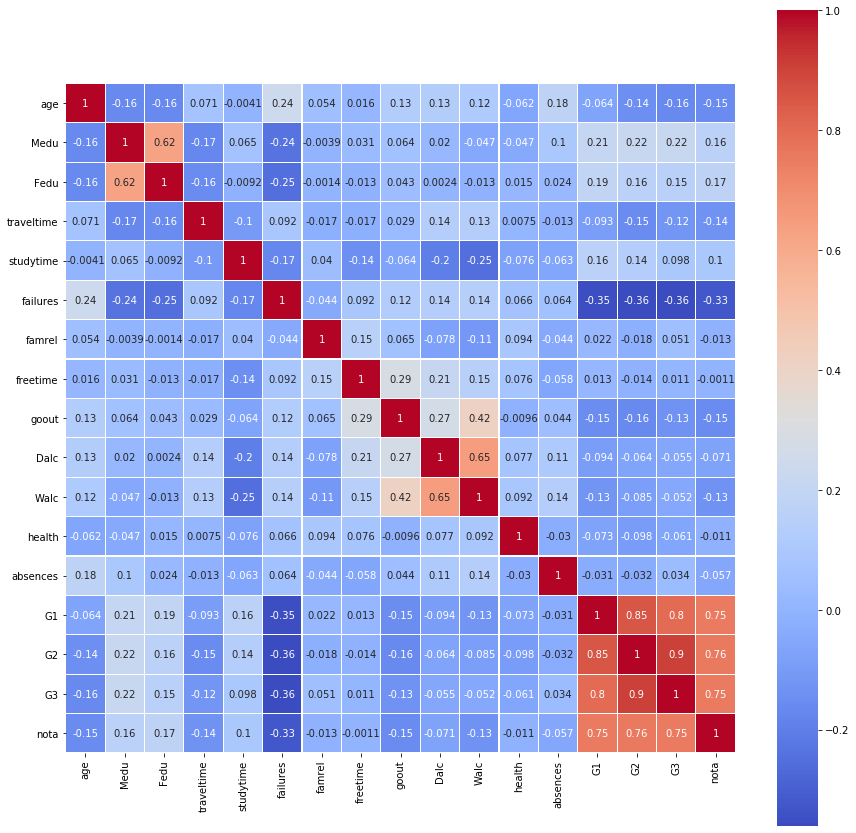

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(df_new.select([c for c in df_new]).toPandas().corr(), linewidths=0.1, vmax=1.0, square=True, linecolor="white", annot=True, cmap="coolwarm")
plt.show()
plt.gcf().clear()

Las variables altamente correlacionadas, como es de esperar, son las relativas a la nota de cada trimestre.

<div id="model" />

## Modelo y ajuste de parámetros

<div id="lr" />

### Linear Regression

En primer lugar aplicamos un modelo de regresión lineal generalizada (sin eliminación de variables correlacionadas). Intentaremos predecir el valor de la variable `G3`.

In [8]:
from pyspark.ml.feature import VectorAssembler as VA
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Baseremos nuestro modelo de acuerdo a las siguientes variables
filter_cols = [x for x in columns if x != "G3" and x != "nota"]

vector_assem = VA(inputCols=filter_cols, outputCol="features")

bd = vector_assem.transform(df_new).select(col("G3").alias("label"), "features")
bd.show(3)

splits = bd.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

lr = LinearRegression(maxIter=100, regParam=0.0, solver="normal", labelCol="label", featuresCol="features")
lr_model = lr.fit(train)

predict_train = lr_model.transform(train)
predict_test = lr_model.transform(test)
#predict_test.show(3)

print("Intercept: {0}".format(lr_model.intercept))
print("Coefficients: {0}".format(lr_model.coefficients))
print(" ")

ev = RegressionEvaluator(labelCol = "label")
print("RMSE test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "rmse"})))
print("MAE test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "mae"})))
print("R2 test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "r2"})))

trainingSummary = lr_model.summary
print("R2 training: %f" % trainingSummary.r2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    6|[18.0,4.0,4.0,2.0...|
|    6|[17.0,1.0,1.0,1.0...|
|   10|[15.0,1.0,1.0,1.0...|
+-----+--------------------+
only showing top 3 rows

Intercept: -0.5766709395859213
Coefficients: [-0.2106134561887048,0.14551512015264312,-0.17579547178809357,0.10833057387063091,-0.13096218155007838,-0.15095030559782988,0.37002069897701506,0.13545409591941565,-0.029987417471346887,-0.12768241789781443,0.17786046694141514,0.06334230110520964,0.03765859307075819,0.15149315880460426,0.987300760988007]
 
RMSE test: 1.8896130108013185
MAE test: 1.2080184217014969
R2 test: 0.8274629168197903
R2 training: 0.838872


A continuación un mostramos un gráfico que nos puede dar cierta intuición sobre el error del modelo

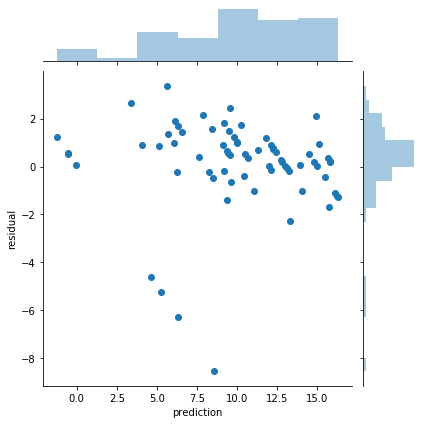

In [9]:
pred = predict_test.withColumn("residual", predict_test.label - predict_test.prediction)

pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="residual", data=pdpred)

<div id="pca" />

### PCA

En este caso reducimos el conjunto de variables mediante PCA y aplicamos nuevamente el modelo de regresión logística.

In [10]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

vector_assem = VA(inputCols=filter_cols, outputCol="features")

bd = vector_assem.transform(df_new).select(col("G3").alias("label"), "features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(bd)
bd_scaled = scalerModel.transform(bd)

print("Conjunto de datos estandarizados: ")
bd_scaled.select("features", "scaledFeatures").show(3)

# 2 componentes

pca = PCA(k=9, inputCol="scaledFeatures", outputCol="pca_scaled_features")
pca_model = pca.fit(bd_scaled)

pca_data_scaled = pca_model.transform(bd_scaled)
#pca_data_scaled.select("scaledFeatures", "pca_scaled_features").show(5)

print("Porcentaje de varianza explicada: ", pca_model.explainedVariance.sum())

# Extraemos la primera y segunda componente

p1 = udf(lambda v:float(v[0]), FloatType())
p2 = udf(lambda v:float(v[1]), FloatType())

pca_data_scaled = pca_data_scaled.withColumn("pca1", p1("pca_scaled_features")).withColumn("pca2", p2("pca_scaled_features"))
pca_data_scaled.select("pca1", "pca2").describe().toPandas()

Conjunto de datos estandarizados: 
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[18.0,4.0,4.0,2.0...|[1.02175063829260...|
|[17.0,1.0,1.0,1.0...|[0.23807781863129...|
|[15.0,1.0,1.0,1.0...|[-1.3292678206913...|
+--------------------+--------------------+
only showing top 3 rows

Porcentaje de varianza explicada:  0.8171336041743067


,summary,pca1,pca2
0,count,395,395
1,mean,-4.978154939186724E-9,1.3144616084762766E-9
2,stddev,1.6837856843158685,1.4131022566753797
3,min,-5.716046,-3.809432
4,max,4.2270727,4.6855984


Con 9 componentes principales podemos explicar el 80% de la varianza. Resulta una alta cantidad de componentes en relación al bajo número de variables de nuestro dataset. Esto se debe a que la mayoría de variables iniciales (prácticamente todas) no se encuentran correlacionadas.

Entrenaremos ahora un nuevo modelo de regresión con los datos reducidos mediante `PCA`

In [11]:
#from pyspark.ml.feature import VectorAssembler as VA
#from pyspark.sql.functions import col
#from pyspark.ml.regression import LinearRegression
#from pyspark.ml.evaluation import RegressionEvaluator


splits = pca_data_scaled.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

lr = LinearRegression(maxIter=100, regParam=0.0, solver="normal", 
                      labelCol="label", featuresCol="pca_scaled_features")
lr_model = lr.fit(train)

predict_train = lr_model.transform(train)
predict_test = lr_model.transform(test)
#predict_test.show(3)

print("Intercept: {0}".format(lr_model.intercept))
print("Coefficients: {0}".format(lr_model.coefficients))
print(" ")

ev = RegressionEvaluator(labelCol="label")
print("RMSE test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "rmse"})))
print("MAE test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "mae"})))
print("R2 test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "r2"})))

trainingSummary = lr_model.summary
print("R2 training: %f" % trainingSummary.r2)

Intercept: 10.403155457423857
Coefficients: [1.702116050805015,1.0562355634038765,1.8695080176916647,0.4523062486648901,-0.11429132685708668,-0.5804382395365091,0.26554882720741013,0.26044069961259575,0.2188838303354091]
 
RMSE test: 2.183577068822952
MAE test: 1.5842416441234681
R2 test: 0.7696046230866502
R2 training: 0.778565


Podemos ver finalmente que nuestro nuevo modelo mediante `PCA` tiene peores métricas.

<div id="rf" />

### Random Forest

Como ejemplo de clasificación usaremos un modelo random forest donde nuestro target será la variable `nota`

In [12]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

# En RandomForestClassifier debemos transformar la variable objetivo a tipo double

#vector_assem = VA(inputCols=filter_cols, outputCol="features")

bd = vector_assem.transform(df_new).select(col("nota").cast("double").alias("label"), "features")

splits = bd.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

rfc = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=5,
                           seed=1234, impurity="gini", featureSubsetStrategy="sqrt")
     
rfc_model = rfc.fit(train)

predict_train = rfc_model.transform(train)
predict_test = rfc_model.transform(test)
predict_test.show(5)

ev = BCE(rawPredictionCol="rawPrediction", labelCol="label")
print("areaUnderROC test: {0}".format(ev.evaluate(predict_test, {ev.metricName: "areaUnderROC"})))
print("areaUnderROC training: {0}".format(ev.evaluate(predict_train, {ev.metricName: "areaUnderROC"})))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[15.0,1.0,1.0,1.0...|[77.7991979799637...|[0.77799197979963...|       0.0|
|  0.0|[15.0,1.0,1.0,1.0...|[93.6554096418193...|[0.93655409641819...|       0.0|
|  0.0|[15.0,1.0,1.0,1.0...|[95.9176440316187...|[0.95917644031618...|       0.0|
|  0.0|[15.0,3.0,2.0,1.0...|[90.8683104275607...|[0.90868310427560...|       0.0|
|  0.0|[15.0,4.0,3.0,2.0...|[86.5366233910687...|[0.86536623391068...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

areaUnderROC test: 0.9802631578947367
areaUnderROC training: 0.9976076555023923


Nuestro modelo tiene muy buenas métricas, entorno a 98%.

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE

cm = predict_test.groupBy("label", "prediction").count().sort("label", "prediction")
cm.show()

TN = cm.filter((cm.label == 0) & (cm.prediction == 0)).collect()[0][2]
FP = cm.filter((cm.label == 0) & (cm.prediction == 1)).collect()[0][2]
FN = cm.filter((cm.label == 1) & (cm.prediction == 0)).collect()[0][2]
TP = cm.filter((cm.label == 1) & (cm.prediction == 1)).collect()[0][2]

N = TN + FP + TP + FN

prevalencia = (TP + FN) / N
sensibilidad = TP / (TP + FN)
especificidad  = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / N

print("Prevalencia: ", prevalencia)
print("Sensibilidad: ", sensibilidad)
print("Especificidad: ", especificidad)
print("Precision: ", precision)
print("Accuracy: ", accuracy)
print("Accuracy (librería): ", MCE(metricName="weightedRecall").evaluate(predict_test))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   31|
|  0.0|       1.0|    1|
|  1.0|       0.0|    2|
|  1.0|       1.0|   36|
+-----+----------+-----+

Prevalencia:  0.5428571428571428
Sensibilidad:  0.9473684210526315
Especificidad:  0.96875
Precision:  0.972972972972973
Accuracy:  0.9571428571428572
Accuracy (librería):  0.9571428571428571


<div id="cv" />

### Cross Validation

Para comparar nuestro modelo previo de random forest, entrenaremos otro modelo de clasificación basado en clasificación logística con selección de parámetros `cross validation`

In [14]:
#from pyspark.ml.feature import VectorAssembler as VA
#from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
#from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

start_time = time.time()

bd = vector_assem.transform(df_new).select(col("nota").cast("double").alias("label"), "features")

train, test = bd.randomSplit([0.8, 0.2])

# Modelo
logr = LogisticRegression(maxIter=10, labelCol="label", featuresCol="features")

paramGrid = ParamGridBuilder().addGrid(logr.regParam, [1, 0.5, 0.1]).addGrid(logr.elasticNetParam, [0.0, 1.0]).build()

# Cross-Validator
crossval = CrossValidator(estimator=logr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BCE(metricName="areaUnderROC"),
                          numFolds=10, 
                          seed=1234)

cvModel = crossval.fit(train)


# Selcción del mejor modelo
best_model = cvModel.bestModel
print("Best value of elasticNet parameter: " + str(best_model._java_obj.getElasticNetParam()))
print("Best value of regularization parameter: " + str(best_model._java_obj.parent().getRegParam()))
print("Best max iterations: " + str(best_model._java_obj.parent().getMaxIter()))


# Evaluación del modelo
pred_test = best_model.transform(test)

ev = BCE(rawPredictionCol="rawPrediction", labelCol="label")
print("areaUnderROC test: {0}".format(ev.evaluate(pred_test, {ev.metricName: "areaUnderROC"})))

print("Tiempo de entrenamiento: ", (time.time() - start_time), "segundos")

Best value of elasticNet parameter: 1.0
Best value of regularization parameter: 0.1
Best max iterations: 10
areaUnderROC test: 0.9880739415623135
Tiempo de entrenamiento:  24.359199047088623 segundos


In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE

cm = pred_test.groupBy("label", "prediction").count().sort("label", "prediction")
cm.show()

TN = cm.filter((cm.label == 0) & (cm.prediction == 0)).collect()[0][2]
FP = cm.filter((cm.label == 0) & (cm.prediction == 1)).collect()[0][2]
FN = cm.filter((cm.label == 1) & (cm.prediction == 0)).collect()[0][2]
TP = cm.filter((cm.label == 1) & (cm.prediction == 1)).collect()[0][2]

N = TN + FP + TP + FN

prevalencia = (TP + FN) / N
sensibilidad = TP / (TP + FN)
especificidad  = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / N

print("Prevalencia: ", prevalencia)
print("Sensibilidad: ", sensibilidad)
print("Especificidad: ", especificidad)
print("Precision: ", precision)
print("Accuracy: ", accuracy)
print("Accuracy (librería): ", MCE(metricName="weightedRecall").evaluate(pred_test))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|   34|
|  0.0|       1.0|    5|
|  1.0|       0.0|    1|
|  1.0|       1.0|   42|
+-----+----------+-----+

Prevalencia:  0.524390243902439
Sensibilidad:  0.9767441860465116
Especificidad:  0.8717948717948718
Precision:  0.8936170212765957
Accuracy:  0.926829268292683
Accuracy (librería):  0.9268292682926829


<div id="conclusion" />

## Conclusión final

A modo resumen, hemos desarrollado los siguientes modelos cada uno de los cuales presenta un caso de uso distinto:

- Linear Regression

- Linear Regression mediante PCA

- Clasificación binaria Random Forest

- Clasificación binaria Logistic Regression mediante Cross Validation